In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import shap

In [39]:
def get_features(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month

    df['emissions_7d_avg'] = df['emissions'].rolling(window=7, min_periods=1).mean()
    df['emission_intensity'] = df['emissions'] / df['production']

    df['timestamp'] = df['timestamp'].dt.strftime('%d-%m-%Y')
    
    return df

In [62]:
def select_features(df, target_col='target', k=5, method='selectkbest'):
    features = df.drop(columns=['timestamp', target_col])
    target = df[target_col]

    if method == 'selectkbest':
        selector = SelectKBest(score_func=f_regression, k=k)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        selector = RFE(estimator=model, n_features_to_select=k)

    selector.fit_transform(features, target)
    selected_columns = features.columns[selector.get_support()]
    
    print(f"Selected features ({method}): {list(selected_columns)}")
    return df[selected_columns], target, selector

In [69]:

def validate_with_shap(X, y):
    model = RandomForestRegressor(n_estimators=1000, random_state=42)
    model.fit(X, y)

    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X)
    return model

In [70]:
dates = pd.date_range(start='01-01-2025', periods=30)
df = pd.DataFrame({
    'timestamp': dates,
    'emissions': np.random.randint(80, 120, size=30),
    'production': np.random.randint(40, 70, size=30)
    })

df['target'] = df['emissions'] * 0.7 + np.random.normal(0, 5, size=30)
df_feat = get_features(df)

In [71]:
df_feat.head(10)

,timestamp,emissions,production,target,day_of_week,month,emissions_7d_avg,emission_intensity
0,01-01-2025,111,63,68.225678,2,1,111.000000,1.761905
1,02-01-2025,85,44,58.899854,3,1,98.000000,1.931818
2,03-01-2025,90,51,46.451377,4,1,95.333333,1.764706
3,04-01-2025,118,51,80.864923,5,1,101.000000,2.313725
4,05-01-2025,106,54,67.585373,6,1,102.000000,1.962963
5,06-01-2025,103,68,64.060139,0,1,102.166667,1.514706
6,07-01-2025,98,62,63.601437,1,1,101.571429,1.580645
7,08-01-2025,103,62,74.049177,2,1,100.428571,1.661290
8,09-01-2025,111,68,80.736583,3,1,104.142857,1.632353
9,10-01-2025,91,53,66.627919,4,1,104.285714,1.716981


Selected features (selectkbest): ['emissions', 'production', 'day_of_week', 'emissions_7d_avg', 'emission_intensity']


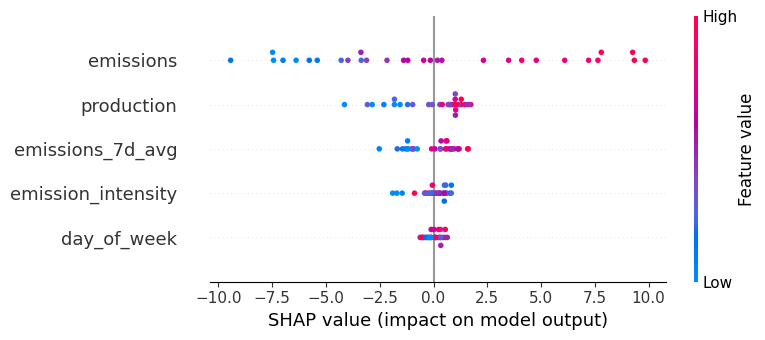

In [72]:
#SelectKBest method
X_selected, y, selector = select_features(df_feat, target_col='target', k=5, method='selectkbest')
model = validate_with_shap(X_selected, y)


Selected features (RFE): ['emissions', 'production', 'day_of_week', 'emissions_7d_avg', 'emission_intensity']


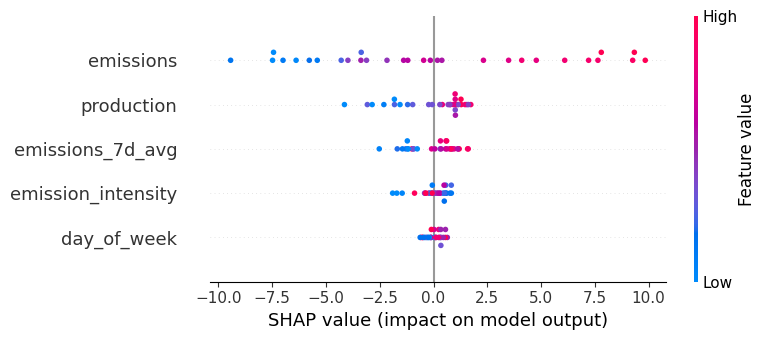

In [73]:
#RFE method
X_selected, y, selector = select_features(df_feat, target_col='target', k=5, method='RFE')
model = validate_with_shap(X_selected, y)


## We can clearly see that emissions is most important feature according to SHAP. it has the biggest impact on the model's output.